In [126]:
import models
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import optim, nn
from torchvision import transforms, datasets
import torchvision.transforms as transforms
import torchvision
import common
from PIL import Image

In [127]:

#DIRECTORY SETTINGS
path='/home/spanthr'
os.chdir("..")#Go up two directories
SAVE_DIR = '/home/spanthr/models'
MODEL_SAVE_PATH = os.path.join(SAVE_DIR, 'base.py')


#HYPERPARAMETERS
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())
EPOCHS=100
BATCH_SIZE = 128
criterion = nn.CrossEntropyLoss()
ADAM_OPTIMISER=False
LEARNING_RATE=0.0005

True


In [128]:
#train_transforms = transforms.Compose([# Data Transforms
#                           transforms.Resize(256),#Resize
#                           transforms.RandomHorizontalFlip(30),#Flip
#                           transforms.RandomRotation(10),#Roatate
#                           transforms.RandomCrop(256),#Crop
#                           transforms.ToTensor(),#Convert to Tensor
#                           transforms.Normalize((0.49139968, 0.48215827, 0.44653124), (0.24703233, 0.24348505, 0.26158768))#Normalize
#                       ])

train_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transforms = transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.49139968, 0.48215827, 0.44653124), (0.24703233, 0.24348505, 0.26158768))
                       ])

In [129]:
#assignment1/CIFAR
train_data = torchvision.datasets.CIFAR10(root='/home/spanthr/CIFAR_DATA/', train=True, download=True, transform=train_transforms)#Use CIFAR10 to train   # Add the root directory to CIFAR here
train_data, valid_data = torch.utils.data.random_split(train_data, [int(len(train_data)*0.9), len(train_data) - int(len(train_data)*0.9)])
test_data = torchvision.datasets.CIFAR10(root='/home/spanthr/CIFAR_DATA/', train=True, download=True, transform=test_transforms)      # Add the root directory to CIFAR here 
 

print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')


train_iterator = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE)
valid_iterator = torch.utils.data.DataLoader(valid_data, batch_size=BATCH_SIZE)
test_iterator = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE)

Files already downloaded and verified
Files already downloaded and verified
Number of training examples: 45000
Number of validation examples: 5000
Number of testing examples: 50000


In [130]:
#model = torchvision.models.resnet18(pretrained=True)#TorchVision
model = torchvision.models.alexnet(pretrained=True)

#for param in model.parameters():
#    param.requires_grad = False
#num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)

# MODEL for parallel
model = model.to(device)
model = nn.DataParallel(model, device_ids=[0,1])
print("Available:", torch.cuda.device_count(), "GPUs")
#Hyperparameters
if(ADAM_OPTIMISER):
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
else:
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.5)

Available: 2 GPUs


In [131]:
#Train

epoch_data=[]
acc_data=[]
val_data=[]
best_valid_loss = float('inf')
for epoch in range(EPOCHS):#Range of Epochs
    print(epoch)
    train_loss, train_acc = common.train(model, device, train_iterator, optimizer, criterion)#Train Loss Calculation
    valid_loss, valid_acc = common.evaluate(model, device, valid_iterator, criterion)#Validation Loss Calculation

    if valid_loss < best_valid_loss:#Validation Loss - Is current lower than the saved validation loss.
        best_valid_loss = valid_loss#Save the best loss (lowest)
        torch.save(model.state_dict(), MODEL_SAVE_PATH)#Save the model
    epoch_data.append(epoch)
    acc_data.append(train_acc)
    val_data.append(valid_acc)

    print(f'| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:05.2f}% | Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:05.2f}% |')


0
| Epoch: 01 | Train Loss: 1.608 | Train Acc: 49.41% | Val. Loss: 0.899 | Val. Acc: 68.83% |
1
| Epoch: 02 | Train Loss: 0.863 | Train Acc: 69.92% | Val. Loss: 0.679 | Val. Acc: 76.68% |
2
| Epoch: 03 | Train Loss: 0.695 | Train Acc: 75.84% | Val. Loss: 0.602 | Val. Acc: 79.10% |
3
| Epoch: 04 | Train Loss: 0.606 | Train Acc: 78.89% | Val. Loss: 0.527 | Val. Acc: 81.60% |
4
| Epoch: 05 | Train Loss: 0.551 | Train Acc: 80.99% | Val. Loss: 0.489 | Val. Acc: 82.42% |
5
| Epoch: 06 | Train Loss: 0.514 | Train Acc: 82.23% | Val. Loss: 0.470 | Val. Acc: 83.55% |
6
| Epoch: 07 | Train Loss: 0.482 | Train Acc: 83.23% | Val. Loss: 0.459 | Val. Acc: 83.24% |
7
| Epoch: 08 | Train Loss: 0.452 | Train Acc: 84.19% | Val. Loss: 0.429 | Val. Acc: 85.04% |
8
| Epoch: 09 | Train Loss: 0.430 | Train Acc: 84.99% | Val. Loss: 0.422 | Val. Acc: 85.27% |
9
| Epoch: 10 | Train Loss: 0.414 | Train Acc: 85.55% | Val. Loss: 0.414 | Val. Acc: 85.49% |
10
| Epoch: 11 | Train Loss: 0.395 | Train Acc: 86.28% | Val

Text(0, 0.5, 'Training Accuracy (%)')

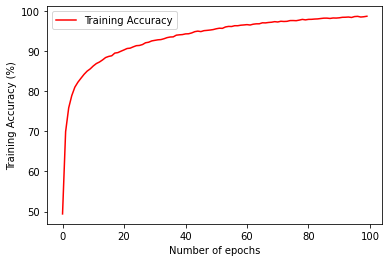

In [149]:
# Plotting 
#my_new_list = [i * 5 for i in my_list]
acc_data1=[i*100 for i in acc_data]
plt.plot(epoch_data,acc_data1,'r-',label="Training Accuracy")
#plt.plot(epoch_data,val_data,'b-',label="Training Accuracy")
plt.legend()
plt.xlabel("Number of epochs")
plt.ylabel("Training Accuracy (%)")
#plt.savefig("epoch_traing.png")

Text(0, 0.5, 'Accuracy in PERCENT(%)')

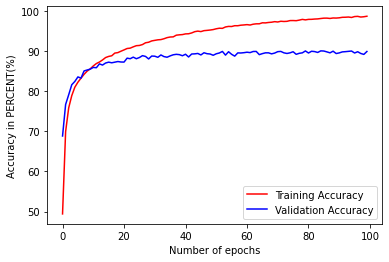

In [151]:

# Plotting 
#my_new_list = [i * 5 for i in my_list]
acc_data3=[i*100 for i in acc_data]
val_data3=[i*100 for i in val_data]
plt.plot(epoch_data,acc_data1,'r-',label="Training Accuracy")
plt.plot(epoch_data,val_data,'b-',label="Validation Accuracy")
plt.legend()
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy in PERCENT(%)")
#plt.savefig("epoch_traing.png")

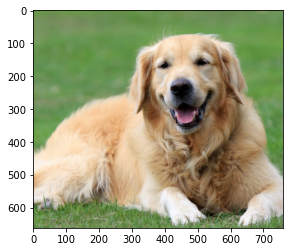

In [152]:
import matplotlib.image as mpimg
tra = transforms.Compose([transforms.Resize((256,256), interpolation=Image.NEAREST), transforms.ToTensor()])
#tra = transforms.Compose([transforms.Resize((32,32)), transforms.ToTensor()])
def image_loader(loader):
    #image=Image.open('home/spanthr/automobile.jpg')
    #plt.imshow(mpimg.imread('home/spanthr/dog.jpg'))
    image=Image.open('home/spanthr/dog.jpg')
    plt.imshow(mpimg.imread('home/spanthr/dog.jpg'))
    image=loader(image).float()
    image=image.unsqueeze(0)
    return image.cuda()
ld = image_loader(tra)

In [153]:

model = model.cuda()
output = model(ld)
a, prediction = torch.max(output.data,1)
prediction = prediction.cpu()
prediction = prediction.numpy()
print(f'catagory:', prediction)
print(a)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

print(classes[prediction[0]])

catagory: [5]
tensor([22.1841], device='cuda:0')
dog


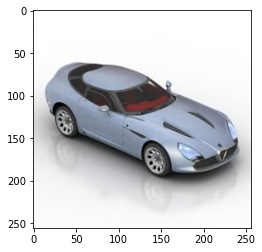

In [154]:
import matplotlib.image as mpimg
tra = transforms.Compose([transforms.Resize((256,256), interpolation=Image.NEAREST), transforms.ToTensor()])
#tra = transforms.Compose([transforms.Resize((32,32)), transforms.ToTensor()])
def image_loader1(loader):
    image=Image.open('home/spanthr/car.jpg')
    plt.imshow(mpimg.imread('home/spanthr/car.jpg'))
    #image=Image.open('home/spanthr/horse.jpg')
    #plt.imshow(mpimg.imread('home/spanthr/horse.jpg'))
    image=loader(image).float()
    image=image.unsqueeze(0)
    return image.cuda()
ld = image_loader1(tra)

In [155]:

model = model.cuda()
output = model(ld)
a, prediction = torch.max(output.data,1)
prediction = prediction.cpu()
prediction = prediction.numpy()
print(f'catagory:', prediction)
print(a)



print(classes[prediction[0]])

catagory: [1]
tensor([11.3139], device='cuda:0')
car


In [156]:
#3. OUTPUT
model.load_state_dict(torch.load(MODEL_SAVE_PATH)) #Load best weights from file
test_loss, test_acc = common.evaluate(model, device, valid_iterator, criterion) #Test Loss is dependent on
print(f'| Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:05.2f}%')

| Test Loss: 0.320 | Test Acc: 89.57%
